## Importing and loading dataset

In [1]:

from datasets import load_dataset

import pandas as pd
import matplotlib.pyplot as plt

from transformers import pipeline

import re
from evaluate import load

In [2]:
df = load_dataset('rodoggx/ATCO2-ASR-1h', split='train')

## Evaluation

In [4]:
modelsList = [
    'openai/whisper-large-v3',
    'Jzuluaga/wav2vec2-xls-r-300m-en-atc-uwb-atcc-and-atcosim',
    'facebook/wav2vec2-base-960h'
]

resultsData = {
    'Model': modelsList,
    'Average WER': [],
    'Lowest WER': [],
    'Highest WER': [],
    'Values': []
}

wer= load('wer')

for model in modelsList:
    totalWER = 0
    itterations = len(df['audio'])
    lowWER = 1
    highWER = 0
    
    temp = []

    pipe = pipeline("automatic-speech-recognition", model=model)

    for i in range(itterations):
        result = pipe(df['audio'][i])
        transcription = df['text Str'][i]

        wer_score = wer.compute(predictions=[result['text'].lower()], references=[transcription.lower()])
        temp.append(wer_score)
        print(wer_score)
        totalWER += wer_score
        if wer_score < lowWER:
            lowWER = wer_score
        if wer_score > highWER:
            highWER = wer_score

    averageWER = totalWER / itterations
    print(f"Average WER for {model}: {averageWER}")
    resultsData['Average WER'].append(averageWER)
    resultsData['Lowest WER'].append(lowWER)
    resultsData['Highest WER'].append(highWER)
    resultsData['Values'].append(temp)

resultsDf = pd.DataFrame.from_dict(resultsData, orient='columns')

: 

In [9]:
resultsDf.to_csv('results.csv')
resultsDf

,Model,Average WER,Lowest WER,Highest WER,Values
0,openai/whisper-large-v3,0.747770,0.090909,12.827586,"[1.0, 0.7948717948717948, 0.9473684210526315, ..."
1,Jzuluaga/wav2vec2-xls-r-300m-en-atc-uwb-atcc-a...,0.501100,0.000000,1.818182,"[0.2, 0.5641025641025641, 0.3157894736842105, ..."
2,facebook/wav2vec2-base-960h,0.932565,0.250000,1.550000,"[0.92, 0.9487179487179487, 1.0, 0.952380952380..."


## Plotting

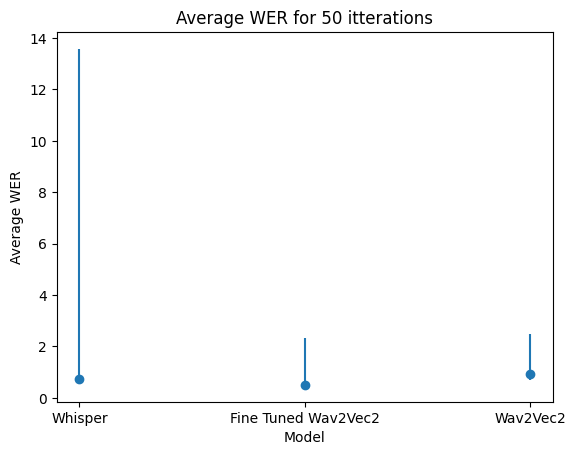

In [7]:
modelNames = [
    'Whisper',
    'Fine Tuned Wav2Vec2',
    'Wav2Vec2'

]

plt.errorbar(
    modelNames,
    resultsDf['Average WER'],
    yerr=[resultsDf['Lowest WER'], resultsDf['Highest WER']],
    fmt='o'
)

plt.xlabel('Model')
plt.ylabel('Average WER')

plt.title('Average WER for 50 itterations')

plt.show()